In [5]:
pip install python-docx

Note: you may need to restart the kernel to use updated packages.


In [3]:
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import time
import datetime

import seaborn as sns


from docx import Document
from docx.shared import Inches
import os

# 1. Recopilación de fuentes y categorización

In [3]:
# #rutas (ALEJANDO - PERSONAL)

# # Ruta base donde se encuentran los archivos shapefile
# base_path = r"C:\Users\Alejandro\Downloads\DATA\SHP"

# output_path_excel = r"C:\Users\Alejandro\Downloads\DATA\Tratados\NAC\EQUIPAMIENTOS\Diccionario_2020.xlsx"
# output_path_gpkg = r"C:\Users\Alejandro\Downloads\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg"

#rutas (ALEJANDO - SSD)

# Ruta base donde se encuentran los archivos shapefile
base_path = r"Z:\VOCES\DATA\SHP"

output_path_excel = r"Z:\VOCES\DATA\Tratados\NAC\EQUIPAMIENTOS\Diccionario_2020.xlsx"
output_path_gpkg = r"Z:\VOCES\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg"

In [9]:
#1.2 Carga de capas de información puntual, de ambos años, en Jupyter

# Lista para almacenar los GeoDataFrames de cada estado
gdfs = []

# Recorrer los números de estado (del 01 al 32)
for i in range(1, 33):
    # Formatear el número del estado como 'XX' (ejemplo: 01, 02, 03...32)
    state_code = f"{i:02d}"
    # Crear la ruta completa del archivo shapefile
    file_path = os.path.join(base_path, f"{state_code}sip.shp")
    
    # Cargar el shapefile y añadirlo a la lista
    gdf_state = gpd.read_file(file_path)
    gdfs.append(gdf_state)

# Unir todos los GeoDataFrames en uno solo
gdf_2020 = gpd.pd.concat(gdfs, ignore_index=True)

# Verificar la unión exitosa
print(f"Total de registros en el archivo unido: {len(gdf_2020)}")

#guardar en gpkg
gdf_2020.to_file(output_path_gpkg, layer='Eq_full_2020')



#1.3 Desplegado de campos únicos

# Agrupar por 'GEOGRÁFICO' y obtener los valores únicos de 'TIPO' para cada uno
diccionario_geografico_tipo = {}

# Recorrer cada valor único de GEOGRAFICO
for geografico in gdf_2020['GEOGRAFICO'].unique():
    # Filtrar los datos correspondientes al valor de 'GEOGRAFICO' actual
    subset = gdf_2020[gdf_2020['GEOGRAFICO'] == geografico]
    
    # Obtener los valores únicos de 'TIPO' asociados a este 'GEOGRAFICO'
    tipos = subset['TIPO'].unique()
    
    # Añadir al diccionario, si no tiene subniveles, ponemos una lista vacía
    diccionario_geografico_tipo[geografico] = list(tipos) if len(tipos) > 0 else []

# Mostrar el diccionario creado
for geo, tipos in diccionario_geografico_tipo.items():
    print(f"{geo}: {tipos}")


#1.4 Desplegado de valores únicos en campos X e Y
#1.5 Exportación de ambas listas en .xlsx

# Convertir el diccionario en un DataFrame para exportar a Excel
data = []

# Recorrer el diccionario y estructurarlo en filas
for geografico, tipos in diccionario_geografico_tipo.items():
    if tipos:  # Si hay subniveles en 'TIPO'
        for tipo in tipos:
            data.append([geografico, tipo])
    else:
        data.append([geografico, None])  # Si no hay subniveles, ponemos 'None' en 'TIPO'

# Crear DataFrame
df_diccionario = pd.DataFrame(data, columns=['GEOGRAFICO', 'TIPO'])

# Exportar a archivo Excel
df_diccionario.to_excel(output_path_excel, index=False)

print(f"Diccionario exportado exitosamente a {output_path_excel}")


Total de registros en el archivo unido: 440164
Centro de Asistencia Médica: ['Centro de Salud', 'Hospital', 'Centro de Rehabilitación']
Escuela: ['Primaria', 'Preescolar', 'Secundaria', 'Medio Superior', 'Superior', 'Mixto']
Templo: ['No Aplica']
Cementerio: ['No Aplica']
Pozo: ['Agua', 'Petróleo', 'Gas']
Instalación Deportiva o Recreativa: ['Cancha', 'Parque', 'Unidad Deportiva', 'Jardín', 'Lienzo Charro', 'Áreas Verdes', 'Estadio', 'Plaza de Toros', 'Campo de Golf', 'Velódromo', 'Balneario', 'Hipódromo', 'Galgódromo', 'Zoológico', 'Alberca Olímpica', 'Campo de Tiro', 'Autódromo', 'Acuario']
Tanque de Agua: ['Tanque Elevado', 'Caja de Agua']
Instalación Gubernamental: ['Palacio de Gobierno', 'Palacio Municipal']
Mercado: ['No Aplica']
Plaza: ['No Aplica']
Instalación Diversa: ['Monumento u Obelisco', 'Silo', 'Planta de Tratamiento de Agua', 'Gasolinera', 'Museo', 'Centro de Investigación', 'Teatro', 'Edificación Cultural', 'Centro de Espectáculos', 'Cine', 'Estación de Gas', 'Observat

# 2. Ponderación y niveles de servicio

In [5]:
# #rutas (ALEJANDRO - PERSONAL)
# equipamientos_gpkg = r"C:\Users\Alejandro\Downloads\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg"
# Diccionario_comentado = r"C:\Users\Alejandro\Downloads\DATA\Tratados\NAC\EQUIPAMIENTOS\Diccionario_pond_2020.xlsx"

#rutas (ALEJANDRO - SSD)
equipamientos_gpkg = r"Z:\VOCES\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg"
Diccionario_comentado = r"Z:\VOCES\DATA\\Tratados\NAC\EQUIPAMIENTOS\Diccionario_pond_2020.xlsx"

In [10]:
# Cargar el diccionario actualizado con las nuevas columnas
diccionario = pd.read_excel(Diccionario_comentado)

# Unir el diccionario con el geodataframe gdf_2020 (asegurarse de que haya un campo en común, por ejemplo 'GEOGRAFICO' y 'TIPO')
gdf_2020 = gdf_2020.merge(diccionario, on=['GEOGRAFICO', 'TIPO'], how='left')

# Filtrar por categorías y exportar a archivos individuales

# Crear una lista de categorías
categorias = ['Educación', 'Salud', 'Recreación', 'Servicios']

# Crear y exportar un GeoDataFrame por cada categoría a una capa dentro del geopackage
for categoria in categorias:
    # Filtrar los equipamientos de la categoría actual
    gdf_categoria = gdf_2020[gdf_2020['CATEGORIA'] == categoria]
    
    # Exportar la categoría como una nueva capa en el geopackage
    gdf_categoria.to_file(equipamientos_gpkg, layer=categoria, driver="GPKG")
    
    print(f"Exportado: {categoria} a la capa {categoria} en el geopackage")

Exportado: Educación a la capa Educación en el geopackage
Exportado: Salud a la capa Salud en el geopackage
Exportado: Recreación a la capa Recreación en el geopackage
Exportado: Servicios a la capa Servicios en el geopackage


# 3. Trabajo a nivel manzana

In [13]:
# # #rutas (ALEJANDRO - PERSONAL)
# manzanas_gpkg_path = r"C:\Users\Alejandro\Downloads\DATA\Tratados\NAC\MZ\Manzanas_NAC.gpkg"
# equipamientos_gpkg = r"C:\Users\Alejandro\Downloads\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg"

#rutas (ALEJANDRO - SSD)
manzanas_gpkg_path = r"Z:\VOCES\DATA\Tratados\NAC\INT_MZN_NAC\Mzn_Tipologías_NAC.gpkg"
equipamientos_gpkg = r"Z:\VOCES\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg"

In [ ]:
#3.1: Cargar el archivo de manzanas

# Cargar el archivo de manzanas
gdf_manzanas = gpd.read_file(manzanas_gpkg_path, layer='Mzn_SubTipologias_ue')


# Crear un buffer de 2 metros alrededor de las manzanas
gdf_manzanas['buffer_2m'] = gdf_manzanas.geometry.buffer(2)

# Establecer el buffer como la geometría activa
gdf_manzanas = gdf_manzanas.set_geometry('buffer_2m')

# Inicializar las columnas para contar equipamientos en cada categoría
gdf_manzanas['num_edu'] = 0
gdf_manzanas['num_sal'] = 0
gdf_manzanas['num_rec'] = 0
gdf_manzanas['num_ser'] = 0

# Lista de categorías y sus respectivas columnas de conteo
categorias = {
    'Educación': 'num_edu',
    'Salud': 'num_sal',
    'Recreación': 'num_rec',
    'Servicios': 'num_ser'
}

In [17]:
# Cargar cada capa de equipamientos desde el geopackage y contar los elementos por manzana
for categoria, columna_conteo in categorias.items():
    # Cargar la capa correspondiente desde el geopackage
    gdf_categoria = gpd.read_file(equipamientos_gpkg, layer=categoria)
    
    # Realizar un join espacial entre los buffers de manzanas y los equipamientos de la categoría
    joined = gpd.sjoin(gdf_manzanas[['buffer_2m']], gdf_categoria, how='left', predicate='contains')
    
    # Contar los equipamientos de la categoría por cada manzana
    gdf_manzanas[columna_conteo] = joined.groupby(joined.index)['index_right'].count()

    print(f"Conteo completado para la categoría: {categoria}")

#borrar columna del buffer
gdf_manzanas = gdf_manzanas.drop(columns=['buffer_2m'])

# Establecer el buffer como la geometría activa
gdf_manzanas = gdf_manzanas.set_geometry('geometry')

#Guardar la capa resultante en un archivo .gpkg
gdf_manzanas.to_file(manzanas_gpkg_path, layer='Mzn_SubTipologias_eq', driver="GPKG")

C:\Users\AMIM GTAC\AppData\Local\Temp\ipykernel_10664\2925549253.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:6372
Right CRS: PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["ITRF2008",DA ...

  joined = gpd.sjoin(gdf_manzanas[['buffer_2m']], gdf_categoria, how='left', predicate='contains')


Conteo completado para la categoría: Educación


C:\Users\AMIM GTAC\AppData\Local\Temp\ipykernel_10664\2925549253.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:6372
Right CRS: PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["ITRF2008",DA ...

  joined = gpd.sjoin(gdf_manzanas[['buffer_2m']], gdf_categoria, how='left', predicate='contains')


Conteo completado para la categoría: Salud


C:\Users\AMIM GTAC\AppData\Local\Temp\ipykernel_10664\2925549253.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:6372
Right CRS: PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["ITRF2008",DA ...

  joined = gpd.sjoin(gdf_manzanas[['buffer_2m']], gdf_categoria, how='left', predicate='contains')


Conteo completado para la categoría: Recreación


C:\Users\AMIM GTAC\AppData\Local\Temp\ipykernel_10664\2925549253.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:6372
Right CRS: PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["ITRF2008",DA ...

  joined = gpd.sjoin(gdf_manzanas[['buffer_2m']], gdf_categoria, how='left', predicate='contains')


Conteo completado para la categoría: Servicios


In [23]:
#3.3: Aplicación de radios de influencia para los equipamientos

# Definir los valores de radio en metros para cada nivel de servicio
# radio_niveles = {1: 1600, 2: 4800, 3: 14400}  # 1 km, 5 km, 12 km
# radio_niveles = {1: 400, 2: 2400, 3: 9600}  # 1 km, 5 km, 12 km # OP (B)
radio_niveles = {1: 400, 2: 1200, 3: 3600}  # 1 km, 5 km, 12 km # OP (C)


# Define el CRS proyectado que deseas utilizar
CRS_PROYECTADO = 'EPSG:6372' 

# Crear una lista de categorías
categorias = ['Educación', 'Salud', 'Recreación', 'Servicios']

# Cargar cada capa de equipamientos desde el geopackage y contar los elementos por manzana
for categoria in categorias:
    # Cargar la capa correspondiente desde el geopackage
    gdf_categoria = gpd.read_file(equipamientos_gpkg, layer=categoria)

    # Proyecta el GeoDataFrame a un CRS proyectado
    # gdf_categoria = gdf_categoria.set_crs(CRS_PROYECTADO)
    gdf_categoria = gdf_categoria.to_crs(CRS_PROYECTADO)

    # Crear los buffers basados en el nivel de servicio (campo 'RADIO')
    gdf_categoria['buffer_influencia'] = gdf_categoria.apply(lambda row: row.geometry.buffer(radio_niveles[row['RADIO']]), axis=1)
    
    # Establecer el buffer como la geometría activa
    gdf_categoria = gdf_categoria.set_geometry('buffer_influencia')
    
    #borrar columna del buffer
    gdf_categoria = gdf_categoria.drop(columns=['geometry'])

    # # Proyecta el GeoDataFrame a un CRS proyectado
    # gdf_categoria = gdf_categoria.to_crs(CRS_PROYECTADO)

    #Guardar la capa en un archivo
    gdf_categoria.to_file(equipamientos_gpkg, layer=f"{categoria}_Buffer_C", driver="GPKG")

    print(f"Búffer completado para la categoría: {categoria}")


C:\Users\AMIM GTAC\anaconda3\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Búffer completado para la categoría: Educación


C:\Users\AMIM GTAC\anaconda3\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Búffer completado para la categoría: Salud


C:\Users\AMIM GTAC\anaconda3\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Búffer completado para la categoría: Recreación
Búffer completado para la categoría: Servicios


C:\Users\AMIM GTAC\anaconda3\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [ ]:
############## Siguiente proceso se realiza mediante QGIS

# Cargar la capa de manzanas, y las 4 capas de búffers de equipamientos

# Utilizar Join atributtes by location (summary), para sumar cada categoría a las manzanas, de forma consecuente

# Refactorizar para renombrar los campos creados

# Guardar dentro del geopackage de la base de datos

In [3]:
# Cargar capas de manzanas y equipamientos
manzanas = gpd.read_file(r"Z:\VOCES\DATA\Tratados\NAC\INT_MZN_NAC\Mzn_Tipologías_NAC.gpkg", layer = 'Mzn_SubTipologias_eq')

ruta_buffers = {
    'EDU': 'Educación',
    'SAL': 'Salud',
    'REC': 'Recreación',
    'SER': 'Servicios'}

print(1)

1


In [18]:
# Función para sumar importancia por categoría
def sumar_importancia_por_categoria(manzanas, buffers, categoria):

    if not manzanas.crs == buffers.crs:
        buffers = buffers.set_crs(manzanas.crs)
    
    # Realizar la intersección espacial
    interseccion = gpd.overlay(manzanas, buffers, how='intersection')
    
    # Agrupar por cada manzana y sumar los valores de importancia
    suma_importancias = interseccion.groupby('manzana_id').agg({
        'IMP': 'sum',
        'IMP_B': 'sum',
        'IMP_C': 'sum'
    }).reset_index()
    
    # Renombrar las columnas resultantes
    suma_importancias = suma_importancias.rename(columns={
        'IMP': f'IMP_{categoria}',
        'IMP_B': f'IMP_B_{categoria}',
        'IMP_C': f'IMP_C_{categoria}'
    })
    
    # Unir las sumas de importancia a la capa original de manzanas
    manzanas = manzanas.merge(suma_importancias, on='manzana_id', how='left')
    
    print(f'resultado completado para {categoria}')

    return manzanas

In [ ]:
for categoria, rutas in ruta_buffers.items():
    # Cargar la capa de buffers por categoría
    buffer_layer = gpd.read_file(r"Z:\VOCES\DATA\Tratados\NAC\EQUIPAMIENTOS\Equipamientos_NAC_2020.gpkg", layer=f'{rutas}_Buffer_B')

    manzanas = sumar_importancia_por_categoria(manzanas, buffer_layer, f'{categoria}')

In [ ]:
# Exportar el resultado a un nuevo geopackage
manzanas.to_file('Z:/VOCES/DATA/Tratados/NAC/EQUIPAMIENTOS/salida_equipamientos.gpkg', layer='manzanas_con_importancia', driver='GPKG')

print("Proceso completado y archivo exportado.")

In [ ]:
# # 3.4: Sumar los valores de ponderación por manzana

# # Inicializar las columnas de importancia por categoría
# gdf_manzanas['IMP_EDU'] = 0
# gdf_manzanas['IMP_SAL'] = 0
# gdf_manzanas['IMP_REC'] = 0
# gdf_manzanas['IMP_SER'] = 0

# # Diccionario que asocia las categorías con las columnas de importancia
# categorias = {
#     'Educación': 'IMP_EDU',
#     'Salud': 'IMP_SAL',
#     'Recreación': 'IMP_REC',
#     'Servicios': 'IMP_SER'
# }

# print(f'1 - {datetime.datetime.now().time()}')

# # Dividir el GeoDataFrame de manzanas en partes más pequeñas
# chunk_size = 20000  # Ajusta el tamaño según la memoria disponible
# manzanas_chunks = np.array_split(gdf_manzanas, len(gdf_manzanas) // chunk_size)

# # Procesar cada bloque de manzanas y sumarle la importancia de los equipamientos que intersectan
# result_chunks = []

# print(f'2 - {datetime.datetime.now().time()}')

# for i, chunk in enumerate(manzanas_chunks):
#     print(f"Procesando bloque {i+1} de {len(manzanas_chunks)}")

#     # Copiar el chunk para no modificar el original
#     chunk_copy = chunk.copy()
    
#     for categoria, columna_importancia in categorias.items():
        
#         # Join espacial entre el chunk de manzanas y los equipamientos por categoría usando el buffer de influencia
#         joined = gpd.sjoin(
#             chunk_copy, 
#             gdf_categoria[['buffer_influencia', 'IMPORTANCIA']], 
#             how='left', 
#             predicate='intersects',
#             lsuffix='mz', 
#             rsuffix='eq'
#         )
        
#         # Sumar la importancia de los equipamientos que caen dentro de cada manzana
#         sum_importancia = joined.groupby(joined.index)['IMPORTANCIA'].sum()
        
#         # Actualizar la columna de importancia en el chunk original
#         chunk_copy[columna_importancia] += chunk_copy.index.map(sum_importancia).fillna(0)

#     # Añadir el chunk procesado a la lista de resultados
#     result_chunks.append(chunk_copy)

# print(f'3 - {datetime.datetime.now().time()}')

# # Concatenar todos los chunks procesados para obtener el GeoDataFrame final
# gdf_manzanas_final = pd.concat(result_chunks)

# # Revisar el resultado
# gdf_manzanas_final.head()


# 3.5: Visualización estadística de los valores de importancia por categoría

In [33]:
#rutas (ALEJANDRO - SSD)
manzanas_gpkg_path = r"Z:\VOCES\DATA\Tratados\NAC\INT_MZN_NAC\Mzn_Tipologías_NAC_ImpEq_C.gpkg"
ruta_salida = r"Z:\VOCES\DATA\Tratados\NAC\EQUIPAMIENTOS"
nombre_excel = r"\Eq_Estadisticas_JAL_C.docx"

# Cargar el archivo de manzanas
gdf_manzanas = gpd.read_file(manzanas_gpkg_path, layer='Mzn_Subtipologias_UeEq_C_filtrado')


            IMP_EDU     IMP_EDU_B     IMP_EDU_C       IMP_SAL     IMP_SAL_B  \
count  56885.000000  56885.000000  56885.000000  56885.000000  56885.000000   
mean      45.615399     76.025666   2888.975301      6.743623     11.395799   
std       50.317920     83.863199   3186.801579      5.933815      9.889874   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       12.000000     20.000000    760.000000      2.000000      4.000000   
50%       30.000000     50.000000   1900.000000      5.000000      9.000000   
75%       57.000000     95.000000   3610.000000     10.000000     17.000000   
max      258.000000    430.000000  16340.000000     37.000000     58.000000   

          IMP_SAL_C       IMP_REC     IMP_REC_B     IMP_REC_C       IMP_SER  \
count  56885.000000  56885.000000  56885.000000  56885.000000  56885.000000   
mean      22.705186      9.973508     15.140265     95.457212      7.534517   
std       27.058786      8.042027     12.788232    

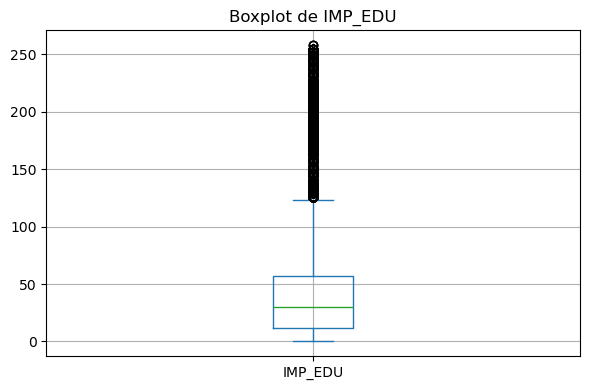

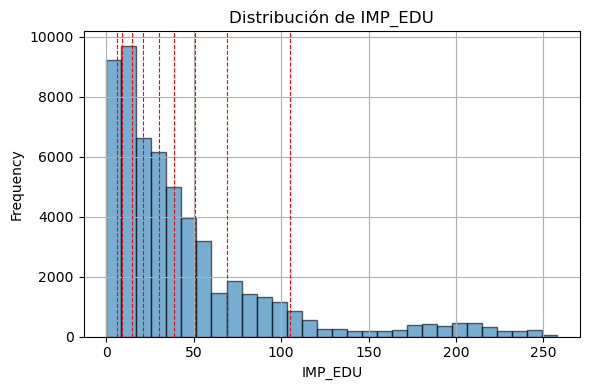

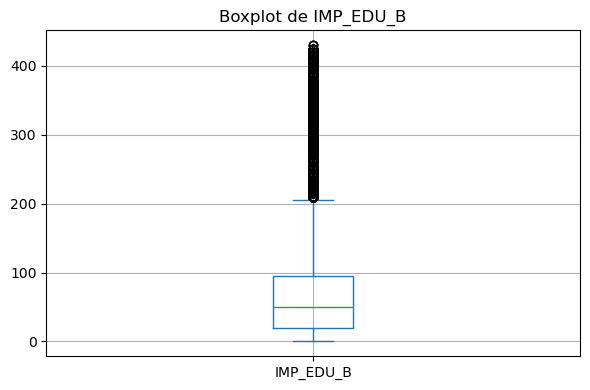

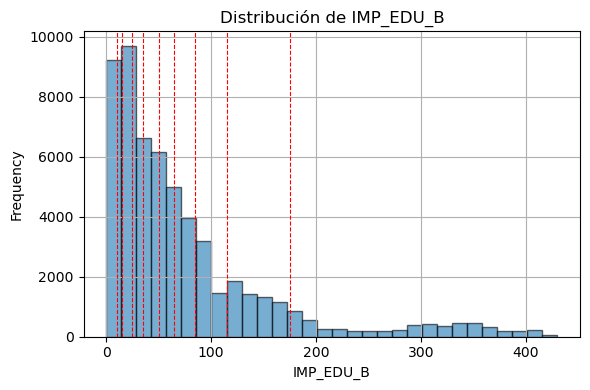

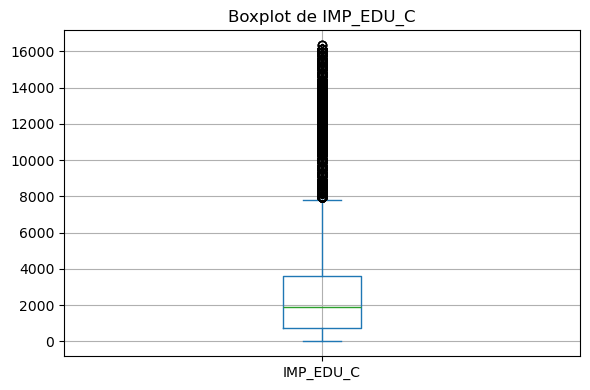

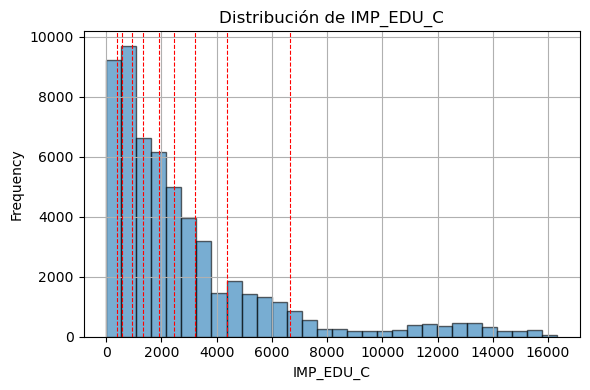

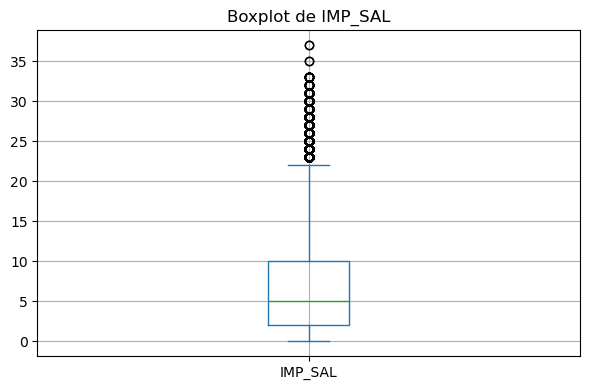

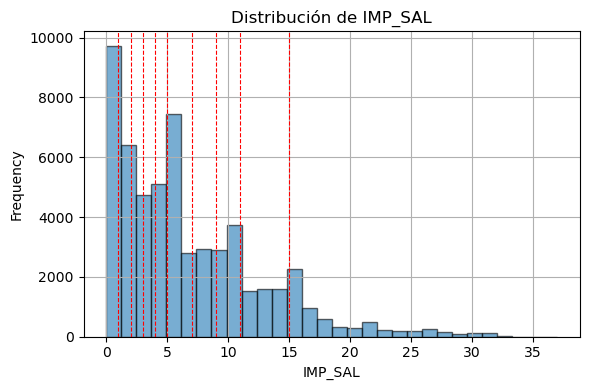

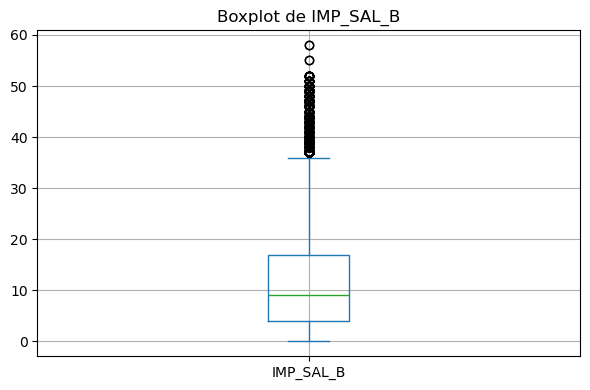

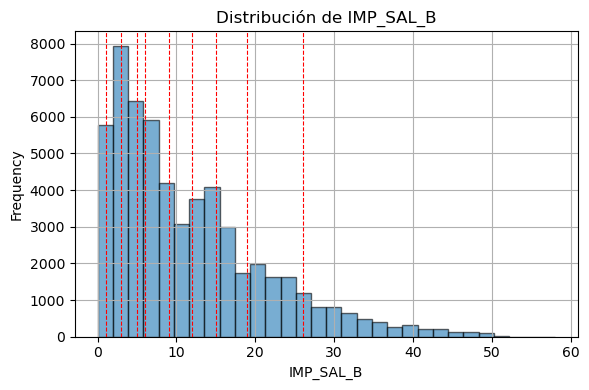

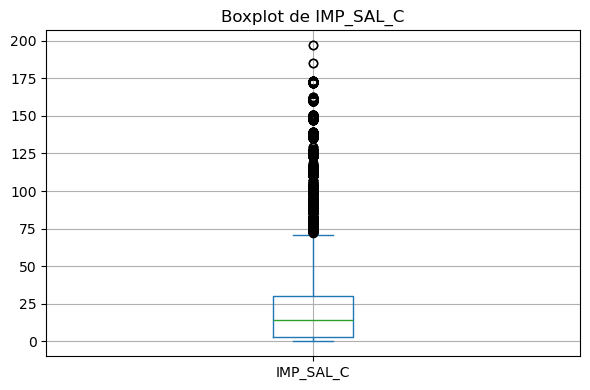

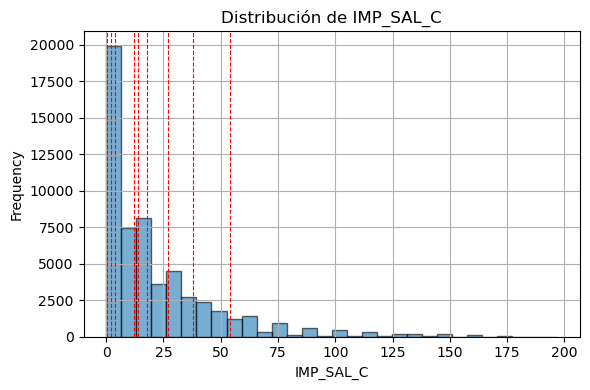

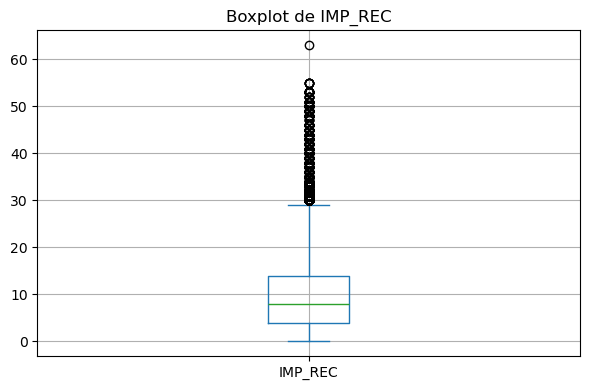

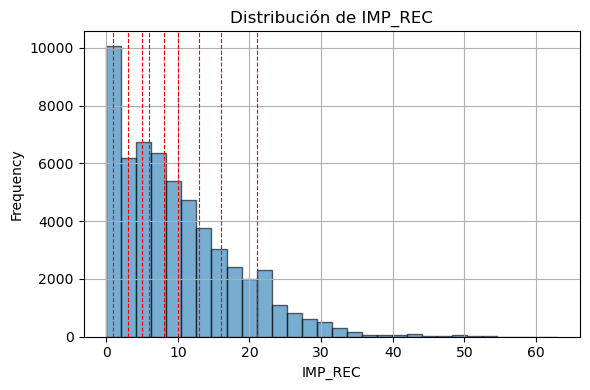

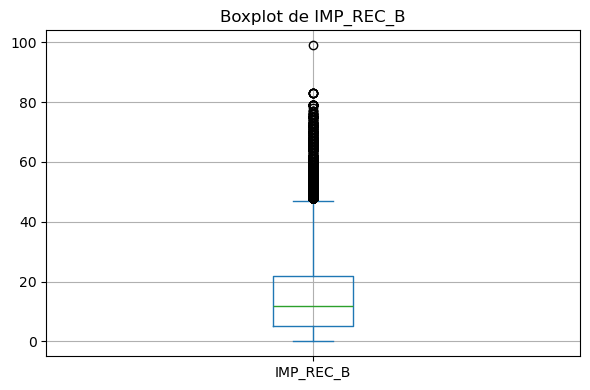

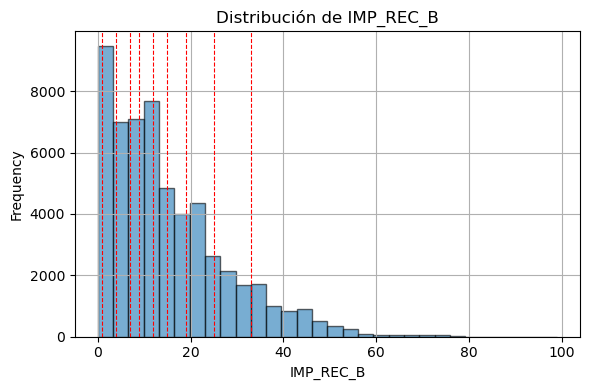

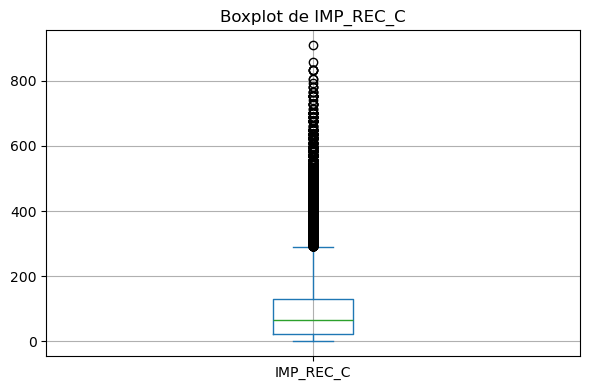

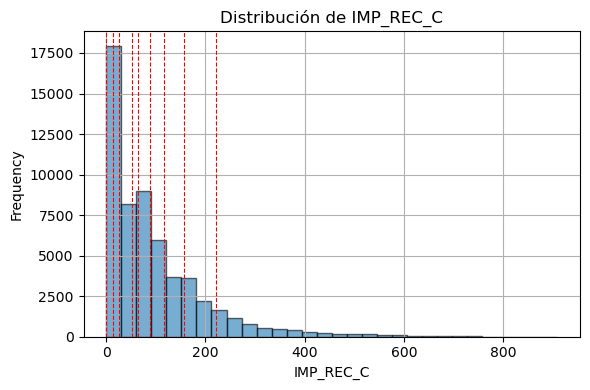

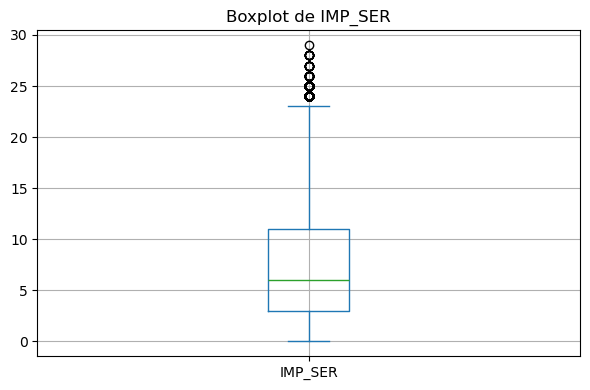

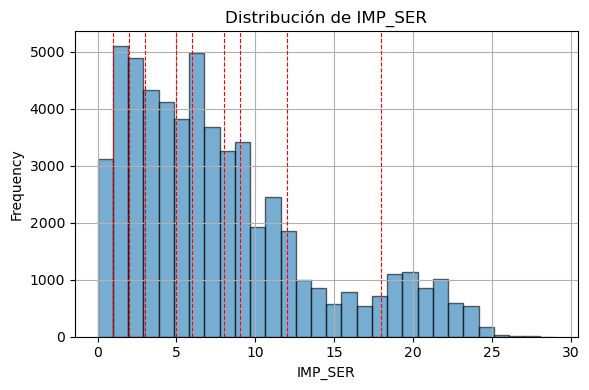

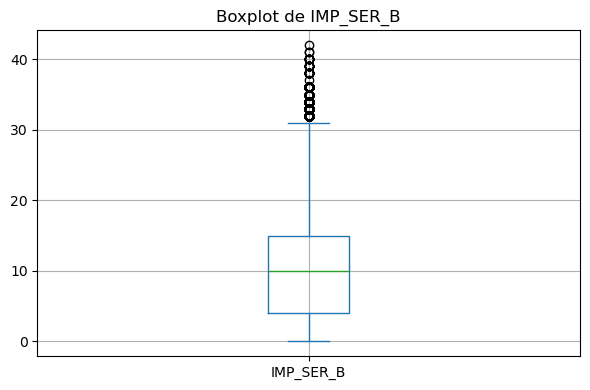

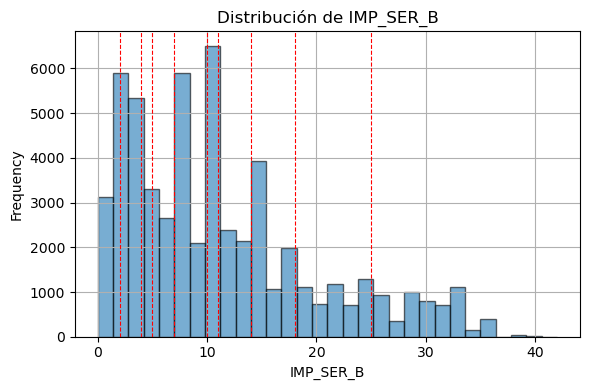

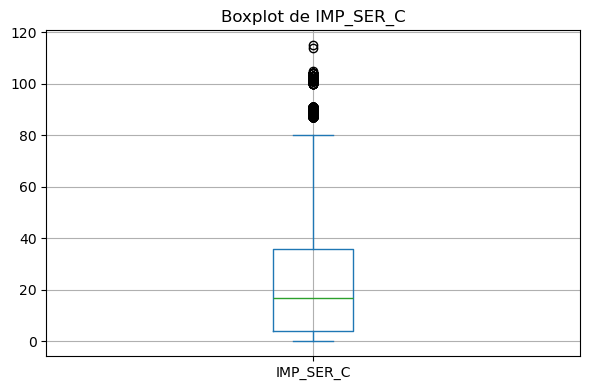

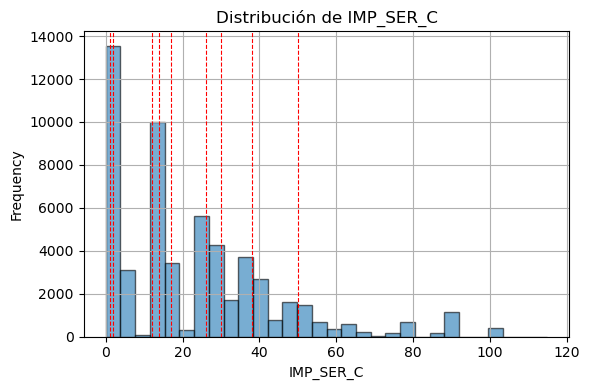

El archivo Word ha sido creado exitosamente como \Eq_Estadisticas_JAL_C.docx


In [35]:
# Supongamos que tus datos están en un DataFrame df y que tus columnas de interés son las siguientes:
columnas_interes = ['IMP_EDU', 'IMP_EDU_B', 'IMP_EDU_C',
                    'IMP_SAL', 'IMP_SAL_B', 'IMP_SAL_C',
                    'IMP_REC', 'IMP_REC_B', 'IMP_REC_C',
                    'IMP_SER', 'IMP_SER_B', 'IMP_SER_C']

# Reemplazar nulos con 0 en las columnas de interés
gdf_manzanas[columnas_interes] = gdf_manzanas[columnas_interes].fillna(0)

# Mostrar estadísticas descriptivas sin notación exponencial
stats = gdf_manzanas[columnas_interes].describe()
print(stats)

# Traducir los nombres de las filas
stats.rename(index={
    'count': 'conteo',
    'mean': 'promedio',
    'std': 'desviación estándar',
    'min': 'mínimo',
    '25%': '25%',
    '50%': 'mediana (50%)',
    '75%': '75%',
    'max': 'máximo'
}, inplace=True)

# Crear un documento de Word
doc = Document()
doc.add_heading('Estadísticas y Visualización de Importancia', level=1)

# Añadir las estadísticas descriptivas como tabla
doc.add_heading('Estadísticas Descriptivas', level=2)

# Añadir la tabla al documento
table = doc.add_table(rows=1, cols=len(stats.columns) + 1)
table.style = 'Table Grid'

# Agregar encabezados a la tabla
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Estadística'
for idx, column in enumerate(stats.columns):
    hdr_cells[idx + 1].text = column

# Agregar los datos de las estadísticas a la tabla
for index, row in stats.iterrows():
    row_cells = table.add_row().cells
    row_cells[0].text = str(index)
    for idx, value in enumerate(row):
        row_cells[idx + 1].text = f"{value:,.2f}"  # Formato para evitar notación exponencial y limitar a dos decimales

# Iterar sobre las columnas de interés
for columna in columnas_interes:
    
    # Crear boxplot
    plt.figure(figsize=(6, 4))
    gdf_manzanas[columna].plot(kind='box')
    plt.title(f'Boxplot de {columna}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{columna}_boxplot.png')  # Guardar la gráfica como imagen
    doc.add_picture(f'{columna}_boxplot.png', width=Inches(6))  # Agregar la imagen al documento
    plt.show()  # Mostrar la gráfica en el entorno de Python
    
    # Crear gráfico de distribución con líneas de deciles
    plt.figure(figsize=(6, 4))
    gdf_manzanas[columna].plot(kind='hist', bins=30, alpha=0.6, edgecolor='black')
    for decil in range(1, 10):
        decil_value = gdf_manzanas[columna].quantile(decil / 10)
        plt.axvline(decil_value, color='red', linestyle='--', linewidth=0.8)
    plt.title(f'Distribución de {columna}')
    plt.xlabel(columna)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{columna}_distribution.png')  # Guardar la gráfica como imagen
    doc.add_picture(f'{columna}_distribution.png', width=Inches(6))  # Agregar la imagen al documento
    plt.show()  # Mostrar la gráfica en el entorno de Python

# Guardar el documento
doc.save(ruta_salida+nombre_excel)
print(f"El archivo Word ha sido creado exitosamente como {nombre_excel}")

# Asignación de valores y claves

In [100]:
#rutas (ALEJANDRO - SSD)
manzanas_gpkg_path = r"Z:\VOCES\DATA\Tratados\NAC\INT_MZN_NAC\Mzn_Tipologías_NAC_ImpEq_C.gpkg"
capa = 'Mzn_Subtipologias_UeEq_C_filtrado'

# Cargar el archivo de manzanas
gdf_manzanas = gpd.read_file(manzanas_gpkg_path, layer=capa)


## IMP A

In [102]:
# Definir función para asignar las letras según los rangos de cobertura de la Tabla 1
def asignar_rango(valor, categoria):
    if categoria == 'EDU':
        if valor < 18:
            return 'D'
        elif 18 <= valor <= 36:
            return 'C'
        else:
            return 'S'
    elif categoria == 'SAL':
        if valor < 4:
            return 'D'
        elif 4 <= valor <= 6:
            return 'C'
        else:
            return 'S'
    elif categoria == 'REC':
        if valor < 21:
            return 'D'
        elif 21 <= valor <= 37:
            return 'C'
        else:
            return 'S'
    elif categoria == 'SER':
        if valor < 32:
            return 'D'
        elif 32 <= valor <= 76:
            return 'C'
        else:
            return 'S'

# Aplicar la función a cada columna de importancia para crear las nuevas columnas CVE
gdf_manzanas['CVE_EDU'] = gdf_manzanas['IMP_EDU'].apply(lambda x: asignar_rango(x, 'EDU'))
gdf_manzanas['CVE_SAL'] = gdf_manzanas['IMP_SAL'].apply(lambda x: asignar_rango(x, 'SAL'))
gdf_manzanas['CVE_REC'] = gdf_manzanas['IMP_REC'].apply(lambda x: asignar_rango(x, 'REC'))
gdf_manzanas['CVE_SER'] = gdf_manzanas['IMP_SER'].apply(lambda x: asignar_rango(x, 'SER'))


In [103]:
# Función para contar las ocurrencias de cada letra y asignar la categoría de cobertura
def asignar_categoria_compuesta(fila):
    # Combinar las columnas de cobertura en una lista
    combinacion = [fila['CVE_EDU'], fila['CVE_SAL'], fila['CVE_REC'], fila['CVE_SER']]
    
    # Contar cuántas veces aparece cada letra
    count_S = combinacion.count('S')
    count_C = combinacion.count('C')
    count_D = combinacion.count('D')
    
    # Asignar la categoría en función de los conteos
    if count_S == 4:
        return 'A'  # Superhábit (SSSS)
    elif count_S == 3 and count_C == 1 or (count_C == 2 and count_S == 2):
        return 'B'  # Cobertura plus (SSSC, SSCC)
    elif count_C == 4 or (count_C == 3 and count_S == 1):
        return 'C'  # Cobertura total (CCCC, CCSC)
    elif count_D == 1:
        return 'D'  # Cobertura parcial (CCCD, CCDS, etc.)
    elif count_D >= 2 and count_C <= 2:
        return 'E'  # Deficiencia (DDDC, DDDS, etc.)
    elif count_D == 4:
        return 'F'  # Deficiencia absoluta (DDDD)
    else:
        return np.nan  # En caso de que no haya una combinación válida

# Aplicar la función a cada fila para crear la nueva columna compuesta CVE_EQ
gdf_manzanas['CVE_EQ'] = gdf_manzanas.apply(asignar_categoria_compuesta, axis=1)

## IMP B

In [105]:
# Definir función para asignar las letras según los rangos de cobertura de la Tabla 1
def asignar_rango(valor, categoria):
    if categoria == 'EDU':
        if valor < 30:
            return 'D'
        elif 18 <= valor <= 60:
            return 'C'
        else:
            return 'S'
    elif categoria == 'SAL':
        if valor < 6:
            return 'D'
        elif 4 <= valor <= 9:
            return 'C'
        else:
            return 'S'
    elif categoria == 'REC':
        if valor < 29:
            return 'D'
        elif 21 <= valor <= 59:
            return 'C'
        else:
            return 'S'
    elif categoria == 'SER':
        if valor < 16:
            return 'D'
        elif 32 <= valor <= 27:
            return 'C'
        else:
            return 'S'

# Aplicar la función a cada columna de importancia para crear las nuevas columnas CVE
gdf_manzanas['CVE_EDU_B'] = gdf_manzanas['IMP_EDU_B'].apply(lambda x: asignar_rango(x, 'EDU'))
gdf_manzanas['CVE_SAL_B'] = gdf_manzanas['IMP_SAL_B'].apply(lambda x: asignar_rango(x, 'SAL'))
gdf_manzanas['CVE_REC_B'] = gdf_manzanas['IMP_REC_B'].apply(lambda x: asignar_rango(x, 'REC'))
gdf_manzanas['CVE_SER_B'] = gdf_manzanas['IMP_SER_B'].apply(lambda x: asignar_rango(x, 'SER'))


In [106]:
# Función para contar las ocurrencias de cada letra y asignar la categoría de cobertura
def asignar_categoria_compuesta(fila):
    # Combinar las columnas de cobertura en una lista
    combinacion = [fila['CVE_EDU_B'], fila['CVE_SAL_B'], fila['CVE_REC_B'], fila['CVE_SER_B']]
    
    # Contar cuántas veces aparece cada letra
    count_S = combinacion.count('S')
    count_C = combinacion.count('C')
    count_D = combinacion.count('D')
    
    # Asignar la categoría en función de los conteos
    if count_S == 4:
        return 'A'  # Superhábit (SSSS)
    elif count_S == 3 and count_C == 1 or (count_C == 2 and count_S == 2):
        return 'B'  # Cobertura plus (SSSC, SSCC)
    elif count_C == 4 or (count_C == 3 and count_S == 1):
        return 'C'  # Cobertura total (CCCC, CCSC)
    elif count_D == 1:
        return 'D'  # Cobertura parcial (CCCD, CCDS, etc.)
    elif count_D >= 2 and count_C <= 2:
        return 'E'  # Deficiencia (DDDC, DDDS, etc.)
    elif count_D == 4:
        return 'F'  # Deficiencia absoluta (DDDD)
    else:
        return np.nan  # En caso de que no haya una combinación válida

# Aplicar la función a cada fila para crear la nueva columna compuesta CVE_EQ
gdf_manzanas['CVE_EQ_B'] = gdf_manzanas.apply(asignar_categoria_compuesta, axis=1)

## IMP C

In [108]:
# Definir función para asignar las letras según los rangos de cobertura de la Tabla 1
def asignar_rango(valor, categoria):
    if categoria == 'EDU':
        if valor < 1140:
            return 'D'
        elif 18 <= valor <= 2280:
            return 'C'
        else:
            return 'S'
    elif categoria == 'SAL':
        if valor < 13.5:
            return 'D'
        elif 4 <= valor <= 25.5:
            return 'C'
        else:
            return 'S'
    elif categoria == 'REC':
        if valor < 185.5:
            return 'D'
        elif 21 <= valor <= 521.5:
            return 'C'
        else:
            return 'S'
    elif categoria == 'SER':
        if valor < 18.5:
            return 'D'
        elif 32 <= valor <= 24:
            return 'C'
        else:
            return 'S'

# Aplicar la función a cada columna de importancia para crear las nuevas columnas CVE
gdf_manzanas['CVE_EDU_C'] = gdf_manzanas['IMP_EDU_C'].apply(lambda x: asignar_rango(x, 'EDU'))
gdf_manzanas['CVE_SAL_C'] = gdf_manzanas['IMP_SAL_C'].apply(lambda x: asignar_rango(x, 'SAL'))
gdf_manzanas['CVE_REC_C'] = gdf_manzanas['IMP_REC_C'].apply(lambda x: asignar_rango(x, 'REC'))
gdf_manzanas['CVE_SER_C'] = gdf_manzanas['IMP_SER_C'].apply(lambda x: asignar_rango(x, 'SER'))


In [109]:
# Función para contar las ocurrencias de cada letra y asignar la categoría de cobertura
def asignar_categoria_compuesta(fila):
    # Combinar las columnas de cobertura en una lista
    combinacion = [fila['CVE_EDU_C'], fila['CVE_SAL_C'], fila['CVE_REC_C'], fila['CVE_SER_C']]
    
    # Contar cuántas veces aparece cada letra
    count_S = combinacion.count('S')
    count_C = combinacion.count('C')
    count_D = combinacion.count('D')
    
    # Asignar la categoría en función de los conteos
    if count_S == 4:
        return 'A'  # Superhábit (SSSS)
    elif count_S == 3 and count_C == 1 or (count_C == 2 and count_S == 2):
        return 'B'  # Cobertura plus (SSSC, SSCC)
    elif count_C == 4 or (count_C == 3 and count_S == 1):
        return 'C'  # Cobertura total (CCCC, CCSC)
    elif count_D == 1:
        return 'D'  # Cobertura parcial (CCCD, CCDS, etc.)
    elif count_D >= 2 and count_C <= 2:
        return 'E'  # Deficiencia (DDDC, DDDS, etc.)
    elif count_D == 4:
        return 'F'  # Deficiencia absoluta (DDDD)
    else:
        return np.nan  # En caso de que no haya una combinación válida

# Aplicar la función a cada fila para crear la nueva columna compuesta CVE_EQ
gdf_manzanas['CVE_EQ_C'] = gdf_manzanas.apply(asignar_categoria_compuesta, axis=1)

## GUARDAR

In [111]:
#Guardar la capa resultante en un archivo .gpkg
gdf_manzanas.to_file(manzanas_gpkg_path, layer=capa, driver="GPKG")